In [583]:
import pandas as pd
import numpy as np
import pandas_profiling
import statsmodels.api as sm
from pandas.core import datetools
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
from fbprophet import Prophet
%matplotlib inline

In [321]:
df = pd.read_csv('/Users/jon/dat11syd/project/beijing3.csv')

In [336]:
df.dtypes

year                     int64
month                    int64
day                      int64
hour                     int64
air_qual               float64
dew_point                int64
temp                   float64
pressure               float64
wind_dir                object
wind_spd               float64
snow_hours               int64
rain_hours               int64
cars                   float64
avg_air_qual           float64
date            datetime64[ns]
dtype: object

In [328]:
df.isnull().sum()

year          0
month         0
day           0
hour          0
pm2.5         0
DEWP          0
TEMP          0
PRES          0
cbwd          0
Iws           0
Is            0
Ir            0
cars          0
average_pm    0
date          0
dtype: int64

In [324]:
df.head()

,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,cars,average_pm
0,25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,4000000.0,138.5
1,26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,4000000.0,153.5
2,27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,4000000.0,170.0
3,28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4000000.0,159.5
4,29,2010,1,2,5,109.0,-7,-6.0,1022.0,SE,7.14,3,0,4000000.0,123.5


In [325]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [326]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [329]:
df.rename({'pm2.5':'air_qual', 'DEWP':'dew_point', 'PRES':'pressure', 'cbwd':'wind_dir', 'Iws':'wind_spd',
          'Is': 'snow_hours', 'Ir': 'rain_hours', 'average_pm': 'avg_air_qual', 'TEMP': 'temp'}, axis=1, inplace=True)

In [337]:
# create central heating feature
conditions = [
                df['month'] == 1,
                df['month'] == 2,
                (df['month'] == 3) & (df['day'] < 15),
                (df['month'] == 11) & (df['day'] > 15),
                df['month'] == 12
            ]

choices = [1,1,1,1,1]

df["heating"] = np.select(conditions, choices, default=np.nan)
df['heating'].fillna(0, inplace=True)

In [348]:
air_heat = df.groupby(['month'])['air_qual', 'heating'].mean()
air_heat

,air_qual,heating
month,,
1,115.055043,1.000000
2,125.736140,1.000000
3,97.757593,0.467942
4,83.709251,0.000000
5,80.113051,0.000000
6,96.513656,0.000000
7,94.332328,0.000000
8,79.996704,0.000000
9,85.209421,0.000000


In [347]:
air_heat.corr()

,air_qual,heating
air_qual,1.000000,0.615821
heating,0.615821,1.000000


In [338]:
# create mortaility rate feature

conditions = [df['year'] == 2010,
              df['year'] == 2011,
              df['year'] == 2012,
              df['year'] == 2013,
              df['year'] == 2014
             
             ]

choices = [6.0, 5.75, 5.0, 5.9, 6.1]

df["mortality"] = np.select(conditions, choices, default=np.nan)
#df['heating'].fillna(0, inplace=True)

In [280]:
air_mort = df.groupby(['year'])['air_qual', 'mortality'].mean()

In [281]:
air_mort

,air_qual,mortality
year,,
2010,104.042645,6.00
2011,99.071340,5.75
2012,90.545871,5.00
2013,101.712376,5.90
2014,97.734557,6.10


In [282]:
air_mort.corr()

,air_qual,mortality
air_qual,1.000000,0.840769
mortality,0.840769,1.000000


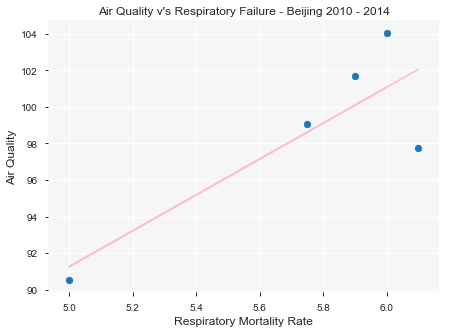

In [569]:
x = air_mort['mortality']
y = air_mort['air_qual']
plt.figure(figsize=(7,5))
plt.rcParams['axes.facecolor']='f6f6f6'
plt.scatter(x,y)
plt.xlabel('Respiratory Mortality Rate', fontsize=12)
plt.ylabel('Air Quality', fontsize=12)
plt.title("Air Quality v's Respiratory Failure - Beijing 2010 - 2014")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"#FFC0CB")
plt.savefig('/Users/jon/Desktop/mortality.png', dpi=300)
plt.show()


In [262]:
air_cars = df.groupby(['year'])['air_qual', 'cars'].mean()

In [263]:
air_cars.corr()

,air_qual,cars
air_qual,1.00000,-0.27748
cars,-0.27748,1.00000


In [264]:
air_cars

,air_qual,cars
year,,
2010,104.042645,4000000.0
2011,99.071340,4300000.0
2012,90.545871,4600000.0
2013,101.712376,4950000.0
2014,97.734557,5300000.0


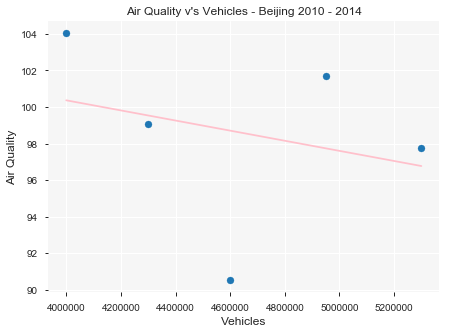

In [568]:
y = air_cars['air_qual']
x = air_cars['cars']
plt.figure(figsize=(7,5))
plt.rcParams['axes.facecolor']='f6f6f6'
plt.ylabel('Air Quality', fontsize=12)
plt.xlabel('Vehicles', fontsize=12)
plt.title("Air Quality v's Vehicles - Beijing 2010 - 2014")
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"#FFC0CB")
plt.savefig('/Users/jon/Desktop/cars.png', dpi=300)

plt.show()

In [573]:
columns = ['year', 'month', 'day', 'hour', 'air_qual', 'dew_point', 'temp', 'pressure','wind_dir', 'wind_spd',
          'snow_hours', 'rain_hours', 'avg_air_qual']
df1 = df[columns]

In [574]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile="/Users/jon/Desktop/beijing_air.html")

In [575]:
y = df1['air_qual']
X = df1[['year', 'month', 'day', 'hour','dew_point','temp', 'pressure','wind_spd','snow_hours', 'rain_hours', 'avg_air_qual']]

In [576]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               air_qual   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.122e+05
Date:                Sat, 05 May 2018   Prob (F-statistic):               0.00
Time:                        17:52:39   Log-Likelihood:            -1.6370e+05
No. Observations:               41756   AIC:                         3.274e+05
Df Residuals:                   41744   BIC:                         3.275e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -58.5034     85.924     -0.681      0.496    -226.917     109.910
year             0.0365      0.043      0.858      0.391      -0.047       0.120
month           -0.0184      0.018     -1.003      0.316      -0.054       0.018
day              0.0051      0.007      0.749      0.454      -0.008       0.019
hour             0.1728      0.009     18.923      0.000       0.155       0.191
dew_point        0.0953      0.009     10.261      0.000       0.077       0.113
temp            -0.1290      0.012    -10.771      0.000      -0.152      -0.106
pressure        -0.0147      0.011     -1.320      0.187      -0.037       0.007
wind_spd        -0.0014      0.001     -1.073      0.283      -0.004       0.001
snow_hours      -0.0639      0.078     -0.823      0.410      -0.216       0.088
rain_hours      -0.3006      0.043     -6.982      0.000      -0.385      -0.216
avg_air_qual     0.9958      0.001   1311.712      0.000       0.994       0.997
==============================================================================
Omnibus:                    16241.604   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13573374.320
Skew:                          -0.238   Prob(JB):                         0.00
Kurtosis:                      91.325   Cond. No.                     3.25e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [571]:
df[['date','air_qual', 'avg_air_qual']].head()

,date,air_qual,avg_air_qual
0,2010-01-02,148.0,138.5
1,2010-01-02,159.0,153.5
2,2010-01-02,181.0,170.0
3,2010-01-02,138.0,159.5
4,2010-01-02,109.0,123.5


In [541]:
feature_columns = ['dew_point','temp','wind_spd','avg_air_qual']
X = df[feature_columns]

In [542]:
y = df['air_qual']

In [543]:
(Xtrain, Xtest, Ytrain, Ytest) = sklearn.model_selection.train_test_split(X,y, test_size=5)

In [544]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, lr.predict(Xtest))

0.9977638650675773

In [545]:
sklearn.metrics.median_absolute_error(Ytest, lr.predict(Xtest))

1.5722740895849583

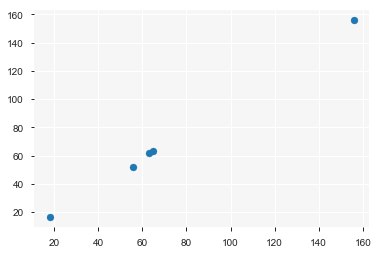

In [546]:
matplotlib.pyplot.scatter(Ytest, lr.predict(Xtest))

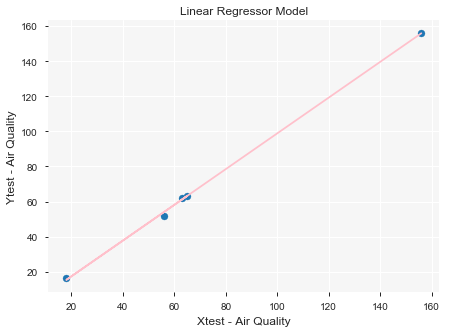

In [567]:
x = Ytest
y = lr.predict(Xtest)
plt.figure(figsize=(7,5))
plt.rcParams['axes.facecolor']='f6f6f6'
plt.scatter(x,y)
plt.xlabel('Xtest - Air Quality', fontsize=12)
plt.ylabel('Ytest - Air Quality', fontsize=12)
plt.title("Linear Regressor Model")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"#FFC0CB")
plt.savefig('/Users/jon/Desktop/linear.png', dpi=300)
plt.show()

In [547]:
elastic = sklearn.linear_model.ElasticNetCV()
elastic.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, elastic.predict(Xtest))

0.9980609431644826

In [548]:
sklearn.metrics.median_absolute_error(Ytest, elastic.predict(Xtest))

1.4276475534078372

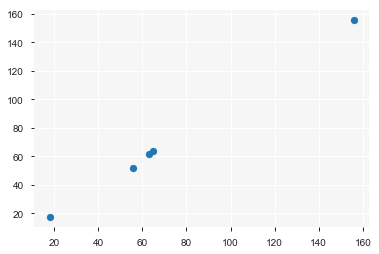

In [549]:
matplotlib.pyplot.scatter(Ytest, elastic.predict(Xtest))

In [550]:
import sklearn.tree
tree = sklearn.tree.DecisionTreeRegressor()
tree.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, tree.predict(Xtest))

0.9855173212837447

In [551]:
sklearn.metrics.median_absolute_error(Ytest, tree.predict(Xtest))

3.0

In [552]:
ts = sklearn.linear_model.TheilSenRegressor()
ts.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, ts.predict(Xtest))

0.993208031673882

In [553]:
sklearn.metrics.median_absolute_error(Ytest, ts.predict(Xtest))

1.946469320138256

In [554]:
ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, ransac.predict(Xtest))

0.9977807567063314

In [555]:
sklearn.metrics.median_absolute_error(Ytest, ransac.predict(Xtest))

1.4113386543647124

In [556]:
huber = sklearn.linear_model.HuberRegressor()
huber.fit(Xtrain, Ytrain)
sklearn.metrics.r2_score(Ytest, huber.predict(Xtest))

0.9982389415540115

In [557]:
sklearn.metrics.median_absolute_error(Ytest, huber.predict(Xtest))

1.1533119403822525

In [577]:
df1 = df.rename(columns={'air_qual': 'y', 'date': 'ds'})

In [578]:
columns1 = ['ds', 'y']

In [580]:
df1 = df1[columns1]

In [581]:
df1.head()

,ds,y
0,2010-01-02,148.0
1,2010-01-02,159.0
2,2010-01-02,181.0
3,2010-01-02,138.0
4,2010-01-02,109.0


In [584]:
# Fit a time series model
m = Prophet(daily_seasonality=True)
m.fit(df1);

/anaconda3/envs/DataScience/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [585]:
#Predict future time series
future = m.make_future_dataframe(periods=360)

In [586]:
# Attach predicted values - yhat
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
42111,2015-12-22,70.014396,-109.983886,250.230498
42112,2015-12-23,71.306997,-118.427632,268.392879
42113,2015-12-24,71.354184,-102.333230,243.072334
42114,2015-12-25,75.347547,-101.356044,271.124136
42115,2015-12-26,81.246393,-86.337655,256.580053


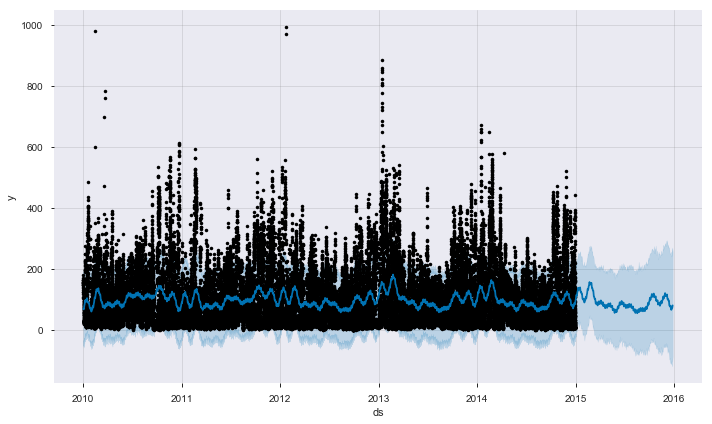

In [587]:
# Plot the forecasted values
m.plot(forecast);

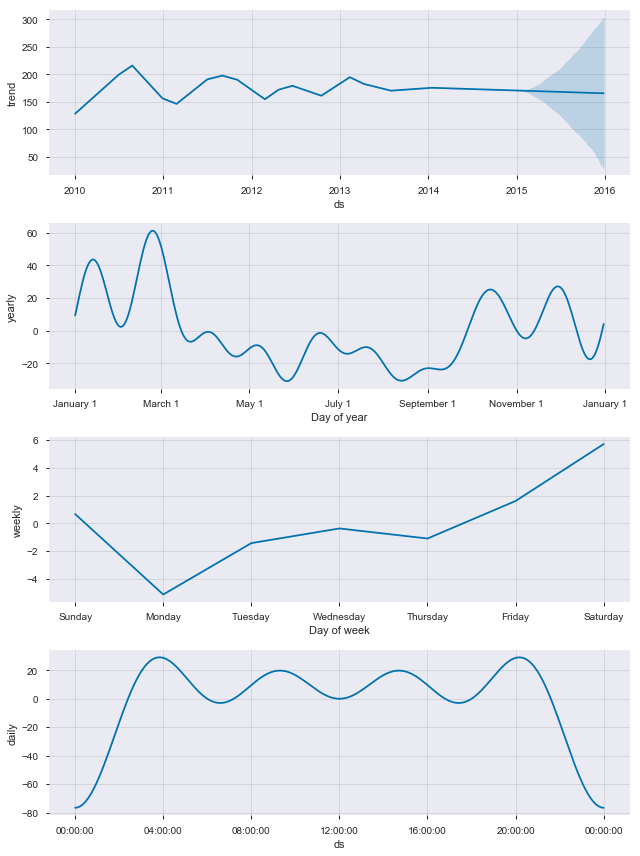

In [588]:
# Time Series Decomposition
m.plot_components(forecast);